# RP IM Sync

### Imports

In [1]:
# Python standard library
import os
import sys
import csv


# Scipy, etc.
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', '')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/rp/')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file

# Jupyter
from IPython.display import HTML

In [21]:
os.getcwd()

'C:\\Users\\SiwyLab\\Desktop\\pore_stats\\notebooks'

### Open files and preprocess data

##### Set file info

In [2]:
date = '11-30-2017'
particle = '/293-T_0'
channel = '/20-10x150_2'
file_index = '0'

base_path = oi_file.data_base_path +date+particle+channel

In [3]:
print(base_path)

C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2


##### Open RP

In [4]:
rp_fps = 250000.


# RP data files
rp_data_file_directory = base_path + '/rp/bts/'
rp_data_file_name = 'test_rp_'+file_index+'.bts'
rp_data_file_path = rp_data_file_directory + rp_data_file_name

rp_data = rp_file.get_data(rp_data_file_path)



# RP event files
rp_events_file_directory = base_path + '/rp/events/'
rp_events_file_name = 'test_rp_' + file_index + '_events.json'
rp_events_file_path = rp_events_file_directory + rp_events_file_name

rp_events = rp_file.open_event_file_json(rp_events_file_path)

##### Open OI

In [5]:
oi_res_x = 384
oi_res_y = 112
oi_fps = 250000
oi_exp = 500*10**(-9.)

# OI data files
oi_vid_file_directory = base_path + '/oi/bin/'
oi_vid_file_name = 'test_camera_' + file_index
oi_vid_file_path = oi_vid_file_directory + oi_vid_file_name

oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# OI event files
oi_events_file_directory = base_path + '/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

In [6]:
print "#rp: ", len(rp_events)
print "#oi: ", len(oi_events)

#rp:  1264
#oi:  1553


##### Open output file

In [7]:
output_file_directory = oi_vid_file_directory.replace('oi/bin/','')
output_file_name = oi_vid_file_name.replace('camera_','') + '_pos_amp'
output_file_path = output_file_directory + output_file_name
print output_file_path

C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2/test_0_pos_amp


##### Create stage

C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2/oi/stage/stage_0.txt
[[60, 72], [60, 47], [316, 43], [317, 68]]
[ 0.01559265  0.99987843]


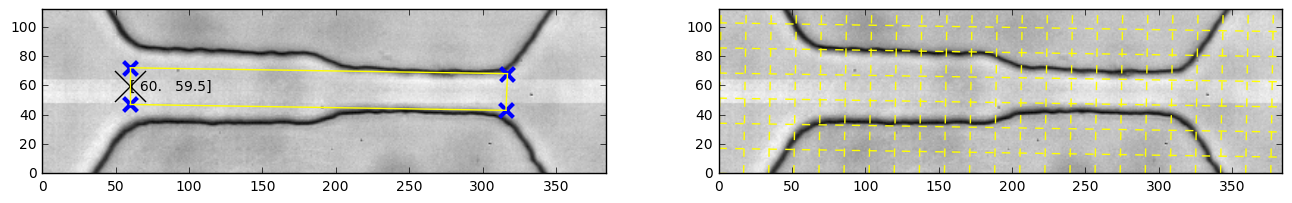

In [8]:
reload(oi)
template_index = 0

template_frame = oi_vid.get_frame(template_index)

stage_file_path = base_path +  '/oi/stage/stage_' + file_index + '.txt'
print stage_file_path
cs = oi.load_stage_file(stage_file_path)
print cs
c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

##### Filter events that do not enter and exit channel

In [9]:
# Get channel enter/exit time
for event in oi_events:
    event.get_channel_enter_exit_tf(oi_stage)

print 'length before:', len(oi_events)
oi_events = [event for event in oi_events if event._channel_enter_tf != None and event._channel_exit_tf != None]
print 'length after:', len(oi_events)

length before: 1553
length after: 1553


##### Sort events by translocation time

In [10]:
def rp_sort(event):
    return np.mean(event._data[:,0])

def oi_sort(event):
    return (event._channel_enter_tf+event._channel_exit_tf)/2.

rp_events = sorted(rp_events, key = rp_sort)
oi_events = sorted(oi_events, key = oi_sort)

In [118]:
for i in range(5):
    #print(rp_events[i]._data[-1,0]-rp_events[i]._data[0,0])
    #print(rp_events[i]._data[-1,1]-rp_events[i]._data[0,1])
    plt.plot(rp_events[i]._data[:,0],rp_events[i]._data[:,1])
    plt.xlim((rp_events[i]._data[0,0]*.9,rp_events[i]._data[-1,0]*1.1))
    #plt.show()
    #plt.savefig('C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2/rp/images')



### Synchronize events

In [11]:
rp_times = np.array([event._data[:,0].mean() for event in rp_events]).reshape(-1,1)
oi_times = np.array([(event._channel_enter_tf+event._channel_exit_tf)/2./oi_fps for event in oi_events]).reshape(-1,1)

In [69]:
step_size = 8*10**-4
int((oi_times[-1][0]-oi_times[1][0])/step_size+(rp_times[-1][0]-rp_times[0][0])/step_size)

7737

In [209]:
int((rp_times[-1][0]-oi_times[-1][0])/step_size)

27419

In [191]:
step_size = 8*10**-3

def find_offset(rp_times,oi_times,step_size):

    num_rp = len(rp_times)
    num_oi = len(oi_times)
    print(num_rp,num_oi)

    step_size = step_size
    total_steps = int((oi_times[-1][0]-oi_times[0][0])/step_size+(rp_times[-1][0]-rp_times[0][0])/step_size)
    #total_steps = 1000
    rp_start = (rp_times-(rp_times[-1]-oi_times[0]))
    sum_list = []

    for i in range(total_steps):
        offset = i*step_size 
        rp_start += offset 
    
        t_sum = 0
        for k in range(num_rp):
            t_sum +=  np.abs(rp_start[k]-oi_times[(np.abs(rp_start[k]-oi_times)).argmin()])
        sum_list.append([t_sum[0],offset])
        #if i%50 == 0:
            #print(i)
            
    return sum_list
    


In [234]:
rp_times.reshape(1,-1)[0]

array([  1.40000000e-04,   3.68000000e-04,   6.21800000e-03, ...,
         4.18894200e+00,   4.19201600e+00,   4.19208600e+00])

In [231]:
rp_times

array([[  1.40000000e-04],
       [  3.68000000e-04],
       [  6.21800000e-03],
       ..., 
       [  4.18894200e+00],
       [  4.19201600e+00],
       [  4.19208600e+00]])

In [236]:
rp_times[np.where(np.logical_and(rp_times.reshape(1,-1)[0]<(oi_times[-1][0]+step_size),rp_times.reshape(1,-1)[0] > (oi_times[0][0]-step_size)))]

array([[  1.40000000e-04],
       [  3.68000000e-04],
       [  6.21800000e-03],
       [  8.76000000e-03],
       [  1.03780000e-02],
       [  1.06740000e-02],
       [  1.66940000e-02],
       [  2.14440000e-02],
       [  3.12400000e-02],
       [  3.68140000e-02],
       [  4.10760000e-02],
       [  4.52760000e-02],
       [  4.53380000e-02],
       [  4.55960000e-02],
       [  4.77220000e-02],
       [  4.98620000e-02],
       [  5.21300000e-02],
       [  6.18240000e-02],
       [  6.32020000e-02],
       [  6.59640000e-02],
       [  6.81860000e-02],
       [  7.45220000e-02],
       [  8.47120000e-02],
       [  8.82840000e-02],
       [  9.32480000e-02],
       [  1.02230000e-01],
       [  1.06406000e-01],
       [  1.07016000e-01],
       [  1.10458000e-01],
       [  1.27834000e-01],
       [  1.27910000e-01],
       [  1.33346000e-01],
       [  1.36322000e-01],
       [  1.36376000e-01],
       [  1.38504000e-01],
       [  1.41886000e-01],
       [  1.43830000e-01],
 

In [293]:
step_size = 8*10**-7
def find_offset2(rp_times,oi_times,step_size):

    num_rp = len(rp_times)
    num_oi = len(oi_times)
    print(num_rp,num_oi)

    step_size = step_size
    total_steps = int((rp_times[-1][0]-oi_times[-1][0])/step_size)
    #total_steps = 1000
    #rp_start = (rp_times-(rp_times[-1]-oi_times[0]))
    sum_list = []
    
    t_sum2 = 1000000
    
    for i in range(total_steps):
        t_sum1 = 0
        offset = i*step_size 
        oi_new = oi_times + offset
        rp_new = rp_times[np.where(np.logical_and(rp_times.reshape(1,-1)[0]<(oi_times[-1][0]+2*step_size),rp_times.reshape(1,-1)[0] > (oi_times[0][0]-2*step_size)))]
    
        
        for k in range(num_oi):
            t_sum1 +=  np.abs(oi_new[k]-rp_new[(np.abs(rp_new-oi_new[k])).argmin()])
        #sum_list.append([t_sum[0],offset])
        if t_sum1 < t_sum2:
            t_sum2 = t_sum1
        else :
            break
            
    return (offset,t_sum2)

In [294]:
b = find_offset2(rp_times,oi_times,step_size)

(1264, 1553)


In [295]:
b

(0.0015072, array([ 2.9767144]))

0


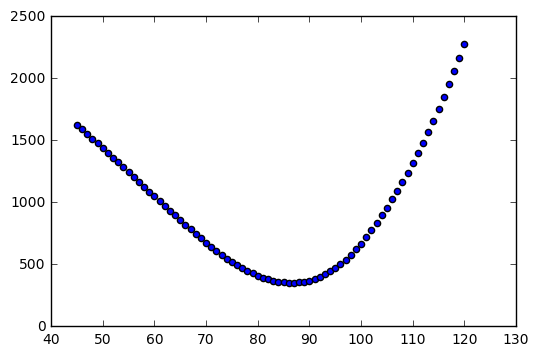

In [130]:
n = []
for i in range(76):
    n.append(i+45)
np.transpose(b)[0][n]

plt.scatter(n,np.transpose(b)[0][n])
plt.show()

In [135]:
print((np.transpose(b)[0])[86],(np.transpose(b)[1])[86])

(351.92023399999943, 0.0688)


In [169]:
(rp_times[-1]-oi_times[0])

array([ 4.191694])

In [292]:
oi_times[0]-rp_times[0]

array([ 0.000252])

[-0.000252]


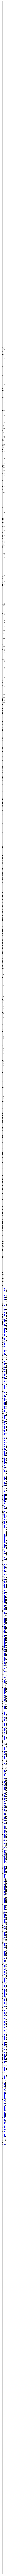

In [12]:
fig = plt.figure(figsize = (.5,500))

offset = rp_times[0]-oi_times[0]

print offset

plt.scatter([0 for i in range(rp_times.shape[0])], rp_times, color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times+offset, color = 'blue')



y_lower = 4.25-oi_fps/float(oi_vid._total_frames)
y_upper = 4.25

for i, event in enumerate(oi_events):
    plt.text(1.25, oi_times[i]+offset, str(i))

for i, event in enumerate(rp_events):
    plt.text(-.25,rp_times[i], str(i))

#plt.ylim(y_lower, y_upper)


plt.show()

##### $\epsilon$ filtering

In [13]:
epsilon_oi_remove_list = []
epsilon_rp_remove_list = []

epsilon = .00005
for i, rp_time in enumerate(rp_times):
    diffs = []
    for j, oi_time in enumerate(oi_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_rp_remove_list.append(i)
        
for i, oi_time in enumerate(oi_times):
    diffs = []
    for j, rp_time in enumerate(rp_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_oi_remove_list.append(i)
        
print epsilon_rp_remove_list
print epsilon_oi_remove_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 211, 212, 213, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,

##### Remove non-matches

In [14]:
rp_remove_list = epsilon_rp_remove_list 
oi_remove_list = epsilon_oi_remove_list 
rp_indices = [i for i in range(len(rp_events)) if i not in rp_remove_list]
oi_indices = [i for i in range(len(oi_events)) if i not in oi_remove_list]

In [15]:
rp_times = np.hstack((np.array([i for i in range(len(rp_events)) if i not in rp_remove_list]).reshape(-1,1),
                      np.array([rp_event._data[:,0].mean() for i, rp_event in enumerate(rp_events)\
                     if i not in rp_remove_list]).reshape(-1,1)))

#oi_times = np.array([(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*fps) for i, oi_event in enumerate(oi_events)\
#                     if i not in oi_remove_list]).reshape(-1,1)

oi_times = np.hstack((np.array([i for i in range(len(oi_events)) if i not in oi_remove_list]).reshape(-1,1),
                      np.array([(1.*oi_event._channel_enter_tf)/(oi_fps) for i, oi_event in enumerate(oi_events)\
                     if i not in oi_remove_list]).reshape(-1,1)))
                      

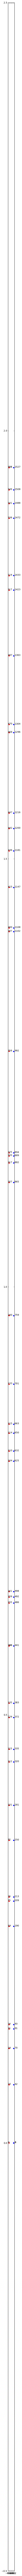

In [16]:
plt.close()
fig = plt.figure(figsize = (.5,200))


plt.scatter([0 for i in range(rp_times.shape[0])], rp_times[:,1], color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times[:,1]+offset[0], color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i,1], str(int(rp_times[i,0])))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i,1] + offset, str(int(oi_times[i,0])))

    
plt.show()

##### Finally, remove

In [17]:
rp_events = [rp_events[i] for i in range(len(rp_events)) if i not in rp_remove_list]
oi_events = [oi_events[i] for i in range(len(oi_events)) if i not in oi_remove_list]

rp_times = [rp_event._data[:,0].mean() for rp_event in rp_events]
oi_times = [(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*oi_fps) for oi_event in oi_events]

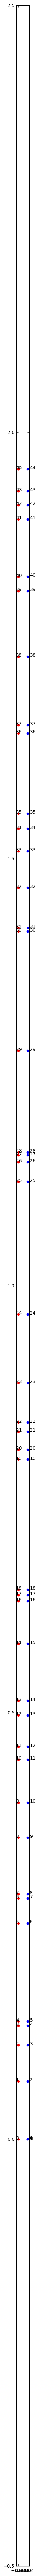

In [18]:
plt.close()
fig = plt.figure(figsize = (.5,100))

offset = rp_times[0]-oi_times[0]

plt.scatter([0 for i in range(len(rp_times))], rp_times, color = 'red')
plt.scatter([1 for i in range(len(oi_times))], oi_times+offset, color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i], str(i))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i] + offset, str(i))

    
plt.show()

##### Save paired events

In [19]:
print len(rp_events), len(oi_events)

rp_events_save_file_path = rp_events_file_path.split('.')[0]+'_sync.json'
oi_events_save_file_path = oi_events_file_path.split('.')[0]+'_sync.json'

print rp_events_save_file_path
print oi_events_save_file_path

46 45
C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2/rp/events/test_rp_0_events_sync.json
C:/Users/SiwyLab/Desktop/Cody/cell_research/cancer_cells/data/11-30-2017/293-T_0/20-10x150_2/oi/events/test_camera_0_events_sync.json


In [20]:
rp_file.save_rp_events_json(rp_events_save_file_path, rp_events)
oi_file.save_oi_events_json(oi_events_save_file_path, oi_events)

In [22]:
offset

-0.00025199999999999995